<h1>City Bus Transit Data Project</h1>

For this project I recorded MBTA route 1 bus data over 2 non-overlapping periods totalling over 64 hours:
- Period 1: from Wednesday, June 14, 17:21 to Thursday, June 15, 01:58, i.e. a period of over 8 hours starting on a weekday in the midst of rush hour (5:30pm) and going all the way to the end of service (approx. 2am).
- Period 2: from Friday, June 16, 17:53 to Monday, June 19, 01:56 (end of service) i.e. a period of 56 hours that covered the weekend -- during which this bus route is still running.

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

### Reading the data 
The data were saved from the mySQL server (in a Docker container) into two csv files, corresponding to the 2 separate periods of recording.

In [2]:
df1 = pd.read_csv('mbta_buses_dataset1.csv', delimiter=",")  
df1.head(3)

,record_num,id,latitude,longitude,label,updated_at,occupancy_status,direction_id,current_stop_sequence
0,311,y1877,42.340530,-71.081480,1877,2023-06-14T17:21:41-04:00,FULL,0,10
1,312,y1863,42.369979,-71.112670,1863,2023-06-14T17:21:43-04:00,FULL,0,22
2,313,y1851,42.359647,-71.094049,1851,2023-06-14T17:22:21-04:00,FEW_SEATS_AVAILABLE,0,15


In [3]:
df1.tail(3)

,record_num,id,latitude,longitude,label,updated_at,occupancy_status,direction_id,current_stop_sequence
15868,16179,y1746,42.371176,-71.114325,1746,2023-06-15T01:58:10-04:00,MANY_SEATS_AVAILABLE,0,23
15869,16180,y1746,42.371875,-71.115206,1746,2023-06-15T01:58:19-04:00,MANY_SEATS_AVAILABLE,0,23
15870,16181,y1746,42.372533,-71.116077,1746,2023-06-15T01:58:29-04:00,MANY_SEATS_AVAILABLE,0,23


In [4]:
df2 = pd.read_csv('mbta_buses_dataset2.csv', delimiter=",")
# Scrubbing this dataset so that "label" is always an int, not a string
df2['label'] = df2['label'].str.extract('(\d+)').astype(int)
df2.head(3)

,record_num,id,latitude,longitude,label,updated_at,occupancy_status,direction_id,current_stop_sequence
0,1,y1911,42.334865,-71.074992,1911,2023-06-16T17:53:09-04:00,FEW_SEATS_AVAILABLE,0,7
1,2,y1857,42.331300,-71.076800,1857,2023-06-16T17:53:09-04:00,FEW_SEATS_AVAILABLE,1,20
2,3,y1842,42.339474,-71.080632,1842,2023-06-16T17:53:05-04:00,FEW_SEATS_AVAILABLE,1,16


In [5]:
df2.tail(3)

,record_num,id,latitude,longitude,label,updated_at,occupancy_status,direction_id,current_stop_sequence
80213,80214,y1795,42.335378,-71.065438,1795,2023-06-19T01:56:00-04:00,MANY_SEATS_AVAILABLE,1,19
80214,80215,y1795,42.335394,-71.065062,1795,2023-06-19T01:56:09-04:00,MANY_SEATS_AVAILABLE,1,19
80215,80216,y1795,42.335394,-71.065062,1795,2023-06-19T01:56:09-04:00,MANY_SEATS_AVAILABLE,1,19


### Concatenating both datasets into one pandas DataFrame and displaying information about the DataFrame

In [6]:
df = pd.concat([df1,df2], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96087 entries, 0 to 96086
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   record_num             96087 non-null  int64  
 1   id                     96087 non-null  object 
 2   latitude               96087 non-null  float64
 3   longitude              96087 non-null  float64
 4   label                  96087 non-null  int64  
 5   updated_at             96087 non-null  object 
 6   occupancy_status       86013 non-null  object 
 7   direction_id           96087 non-null  int64  
 8   current_stop_sequence  96087 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 6.6+ MB


We note from the information displayed above that __the total dataset contains 96,087 entries__ (which were sampled from each running bus on route 1 at 10 seconds intervals over two periods totalling over 64 hours).

<h1>Computing the average time it takes for a bus to complete the route</h1>

Here we are investigating how long it takes, on average, for one vehicle to run from stop 1 to 24 in "direction 0" (Inbound) and how long it takes to run from stop 1 to 24 in "direction 1" (Outbound) -- in case these durations differ depending on the direction.

In [7]:
#  Initialize new pandas DataFrame df_trips 
df_trips = pd.DataFrame(data=[], columns = ['vehicle_id', 'trip_direction', 'trip_start_time', 'trip_end_time', 'trip_end_stop', 'trip_duration'])

# List all unique vehicles (buses) that were active and print their number
ListActiveBuses = df.label.unique()
print('''
Number of unique vehicles (buses) that were active in this dataset, based on their "id" or "label":
''',len(ListActiveBuses))


Number of unique vehicles (buses) that were active in this dataset, based on their "id" or "label":
 54


In [8]:
# Loop over all active buses

for bus_id in ListActiveBuses: 

    t = df['updated_at'].loc[df['label']==bus_id]
    stop = df['current_stop_sequence'].loc[df['label']==bus_id]
    dir = df['direction_id'].loc[df['label']==bus_id]
    TotalTimepoints = len(dir)
    
    # Starting with bus direction at the first data point available (timepoint 0), find when bus direction first switches
    # (and discard all data prior to that point as it is an incomplete leg)
    timepoint = 0
    direction = dir.iloc[timepoint]
    while dir.iloc[timepoint] == direction and timepoint < TotalTimepoints - 1:
        timepoint += 1
    Endtimepoint = timepoint

    # From that switching point, process all the laps/trips done by this bus until the end of the dataset.
    # Note that some buses do not have a single full trip in the dataset and are therefore not counted.
    timepoint = Endtimepoint  # as previously computed
    while timepoint < TotalTimepoints - 1:
        Starttimepoint = Endtimepoint + 1
        timepoint = Starttimepoint
        direction = dir.iloc[timepoint]
        while dir.iloc[timepoint] == direction and timepoint < TotalTimepoints - 1:
            timepoint += 1
        Endtimepoint = timepoint
        # Check if the bus is at the end of the route, using "current_stop_sequence", now named "stop", by
        # checking the value of stop.iloc[timepoint] 
        # Based on preliminary analyses, we define a proper endpoint for the route as any of
        # these 4 stops: 1, 2, 23, 24.
        # If not currently at one of these 4 stops, then the bus has not completed a full leg
        # and we ignore this trip.
        if stop.iloc[timepoint] in {1, 2, 23, 24}: 
            # Compute duration (as a "datetime.timedelta" object)
            Starttime_str = t.iloc[Starttimepoint]
            Endtime_str = t.iloc[Endtimepoint]
            date_format = "%Y-%m-%dT%H:%M:%S%z"
            Starttime = datetime.strptime(Starttime_str, date_format)
            Endtime = datetime.strptime(Endtime_str, date_format)
            Duration = Endtime - Starttime
            # Add this trip as a new row to df_trips
            new_row = pd.Series({'vehicle_id': bus_id, 'trip_direction': direction, 'trip_start_time': Starttime_str, 'trip_end_time': Endtime_str, 'trip_end_stop': stop.iloc[timepoint], 'trip_duration': Duration})
            df_trips = pd.concat([df_trips, new_row.to_frame().T], ignore_index=True)

df_trips


,vehicle_id,trip_direction,trip_start_time,trip_end_time,trip_end_stop,trip_duration
0,1877,1,2023-06-14T17:57:39-04:00,2023-06-14T18:43:16-04:00,2,0 days 00:45:37
1,1877,0,2023-06-14T18:43:25-04:00,2023-06-14T19:23:09-04:00,2,0 days 00:39:44
2,1877,1,2023-06-14T19:23:17-04:00,2023-06-14T20:09:31-04:00,2,0 days 00:46:14
3,1877,0,2023-06-14T20:09:40-04:00,2023-06-14T20:42:20-04:00,1,0 days 00:32:40
4,1877,1,2023-06-14T20:42:32-04:00,2023-06-14T21:16:42-04:00,2,0 days 00:34:10
...,...,...,...,...,...,...
411,1848,0,2023-06-18T21:17:03-04:00,2023-06-18T21:53:53-04:00,2,0 days 00:36:50
412,1848,1,2023-06-18T21:54:06-04:00,2023-06-18T22:32:28-04:00,24,0 days 00:38:22
413,1847,1,2023-06-18T22:36:30-04:00,2023-06-18T23:24:02-04:00,2,0 days 00:47:32
414,1847,0,2023-06-18T23:24:10-04:00,2023-06-18T23:55:58-04:00,2,0 days 00:31:48


In [9]:
df_trips.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   vehicle_id       416 non-null    object         
 1   trip_direction   416 non-null    object         
 2   trip_start_time  416 non-null    object         
 3   trip_end_time    416 non-null    object         
 4   trip_end_stop    416 non-null    object         
 5   trip_duration    416 non-null    timedelta64[ns]
dtypes: object(5), timedelta64[ns](1)
memory usage: 19.6+ KB


As shown in the summary information displayed above, the full dataset contains __416 trips__ worth of data. Now we are going to compute some statistics on trip duration.

In [10]:
# Preliminary statistics from the data before cleanup:
print('Preliminary statistics on trip duration (both directions combined):')
print('Median =             ', df_trips['trip_duration'].median())
print('Mean =               ', df_trips['trip_duration'].mean())
print('Standard deviation = ', df_trips['trip_duration'].std())
print('Minimum =            ', df_trips['trip_duration'].min())
print('Maximum =            ', df_trips['trip_duration'].max())



Preliminary statistics on trip duration (both directions combined):
Median =              0 days 00:40:34
Mean =                0 days 01:10:12.413461538
Standard deviation =  0 days 05:37:35.138223788
Minimum =             0 days 00:00:05
Maximum =             3 days 22:03:45


The above statistics indicate that there is some high level of noise and/or outliers in the data. The data shows very different values for median (40 min) and mean (1 hour 10 min) and a very high variance: the standard deviation is 5.5 hours, which is many times the mean/median value. In addition, the min and max values are unrealistic: 5 seconds and over 3 days, respectively. 

__To reduce noise, here we will be removing trips of a duration longer than 4 hours (i.e. 14400 seconds) and trips shorter than 15 minutes (i.e. 900 seconds).__ Those are estimates of realistic upper and lower bounds for the duration of this route. These estimates are conservative in the sense that we are unlikely to remove any valid data and could potentially use more stringent bounds.

In [11]:
# Displaying rows to be dropped due to unrealistically long trip duration
df_trips.loc[df_trips['trip_duration'].dt.total_seconds()>14400]

,vehicle_id,trip_direction,trip_start_time,trip_end_time,trip_end_stop,trip_duration
7,1877,0,2023-06-14T23:45:17-04:00,2023-06-17T07:53:50-04:00,1,2 days 08:08:33
37,1786,1,2023-06-14T21:58:54-04:00,2023-06-18T20:02:39-04:00,1,3 days 22:03:45
63,1779,1,2023-06-14T18:28:05-04:00,2023-06-15T00:02:27-04:00,1,0 days 05:34:22
97,1857,1,2023-06-16T21:20:32-04:00,2023-06-18T09:49:10-04:00,1,1 days 12:28:38
294,1792,1,2023-06-17T21:18:41-04:00,2023-06-18T07:02:53-04:00,1,0 days 09:44:12
403,1795,1,2023-06-18T15:58:00-04:00,2023-06-18T22:35:03-04:00,1,0 days 06:37:03


In [12]:
# Displaying rows to be dropped due to unrealistically short trip duration
df_trips.loc[df_trips['trip_duration'].dt.total_seconds()<900]

,vehicle_id,trip_direction,trip_start_time,trip_end_time,trip_end_stop,trip_duration
61,1779,1,2023-06-14T17:42:32-04:00,2023-06-14T17:43:05-04:00,1,0 days 00:00:33
64,1779,0,2023-06-15T00:02:27-04:00,2023-06-15T00:09:28-04:00,1,0 days 00:07:01
262,1816,1,2023-06-17T20:38:52-04:00,2023-06-17T20:39:55-04:00,2,0 days 00:01:03
289,1831,0,2023-06-17T19:51:50-04:00,2023-06-17T19:52:53-04:00,1,0 days 00:01:03
292,1792,1,2023-06-17T21:16:40-04:00,2023-06-17T21:16:45-04:00,1,0 days 00:00:05
293,1792,0,2023-06-17T21:16:55-04:00,2023-06-17T21:18:30-04:00,2,0 days 00:01:35


In [13]:
# Remove (drop) trips shorter than 900 seconds or longer than 14400 seconds
df_trips = df_trips.drop(index=df_trips.loc[df_trips['trip_duration'].dt.total_seconds()>14400].index)
df_trips = df_trips.drop(index=df_trips.loc[df_trips['trip_duration'].dt.total_seconds()<900].index)

#### Information about the updated dataset after having removed these outliers

In [14]:
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 0 to 415
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   vehicle_id       404 non-null    object         
 1   trip_direction   404 non-null    object         
 2   trip_start_time  404 non-null    object         
 3   trip_end_time    404 non-null    object         
 4   trip_end_stop    404 non-null    object         
 5   trip_duration    404 non-null    timedelta64[ns]
dtypes: object(5), timedelta64[ns](1)
memory usage: 22.1+ KB


After removing the outliers, we are keeping __404 trips__ out of the 416 entries we previously had. In other words, we removed 12 trips, which sounds like a good, low number.

#### Updated statistics after having removed the outliers

In [15]:
print(df_trips['trip_duration'].median())
print(df_trips['trip_duration'].mean())
print(df_trips['trip_duration'].std())
print(df_trips['trip_duration'].min())
print(df_trips['trip_duration'].max())

# average durations for each direction
print(df_trips['trip_duration'].loc[df_trips['trip_direction']==0].mean())
print(df_trips['trip_duration'].loc[df_trips['trip_direction']==1].mean())

0 days 00:40:34
0 days 00:41:16.957920792
0 days 00:11:54.076203585
0 days 00:19:24
0 days 02:17:08
0 days 00:40:44.678391959
0 days 00:41:48.292682926


These updated statistics (after having removed the 12 outliers) look much better. A standard deviation of about 12 minutes, for a mean duration of 41 minutes, seems very reasonable. The longest trip is now 2 hours and 17 minutes, which can seem very long but not unheard of from Bostonians who take this bus during rush hour and construction!

<h1>Provide a visualization based on the data</h1>

Here we are showing different visualizations of the data.

<h2>Plotting current stop sequence, and direction id, for one bus over the course of 5 hours<h2>


Text(0, 0.5, 'Current stop sequence (blue), direction (orange)')

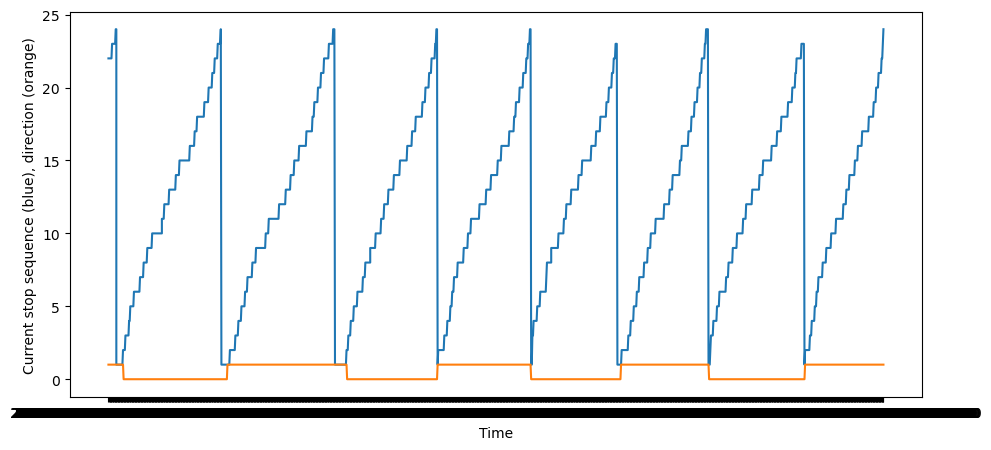

In [16]:
# Taking as an example the bus with id 1778
x = df['updated_at'].loc[df['id']=='y1778']
y = df['current_stop_sequence'].loc[df['id']=='y1778']
z = df['direction_id'].loc[df['id']=='y1778']

fig, ax = plt.subplots(figsize=(11,5))
ax.plot(x,y,x,z)
ax.set_xlabel('Time')
ax.set_ylabel('Current stop sequence (blue), direction (orange)')

The above plot for one bus shows that things are working as expected: the bus goes over each of the 24 stops in sequence, then resets and the direction flips (from 0 to 1 or 1 to 0). 

Next we investigate the duration of the course and how it is distributed over the 404 trips that we have in the dataset.

<h2>Distribution of course duration</h2>

Text(0.5, 0, 'Trip duration, in either direction (minutes)')

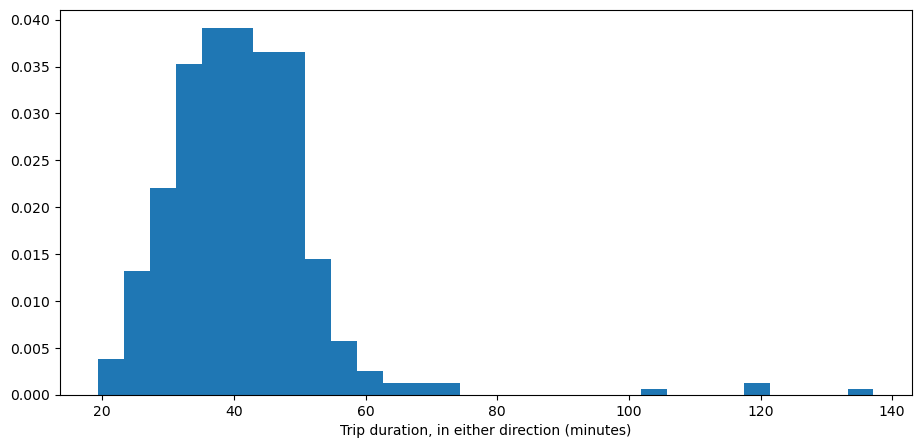

In [17]:
fig, ax = plt.subplots(figsize=(11,5))
x = df_trips['trip_duration'].dt.total_seconds()/60
n,bins,patches = ax.hist(x,30, density=True)
ax.set_xlabel('Trip duration, in either direction (minutes)')


<h2>Distribution of Inbound course duration</h2>

from Harvard Square to Nubian Station ("direction 0")

Text(0.5, 0, 'Inbound (direction 0) trip duration (minutes)')

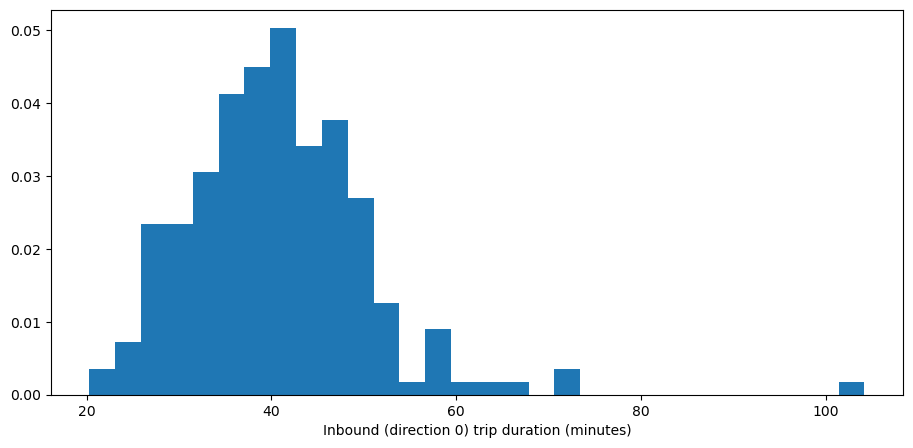

In [18]:
fig, ax = plt.subplots(figsize=(11,5))
x = df_trips['trip_duration'].loc[df_trips['trip_direction']==0].dt.total_seconds()/60
n,bins,patches = ax.hist(x,30, density=True)
ax.set_xlabel('Inbound (direction 0) trip duration (minutes)')

<h2>Distribution of Outbound course duration</h2>

from Nubian Station to Harvard Square ("direction 1")

Text(0.5, 0, 'Outbound (direction 1) trip duration (minutes)')

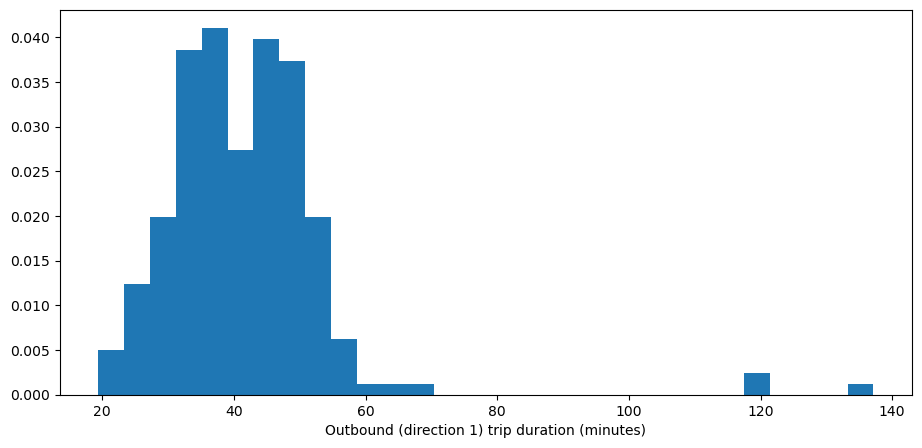

In [19]:
fig, ax = plt.subplots(figsize=(11,5))
x = df_trips['trip_duration'].loc[df_trips['trip_direction']==1].dt.total_seconds()/60
n,bins,patches = ax.hist(x,30, density=True)
ax.set_xlabel('Outbound (direction 1) trip duration (minutes)')

<h1>Estimating the speed of the bus</h1>

Here we are calculating an estimate of the overall average speed of the bus from current_stop_sequence = 1 to the last current_stop_sequence, using two different methods.

<h4>First method: calculating the Haversine distance between stop 1 and stop 24, i.e. between Harvard Square and Nubian Station.</h4>

In [20]:
# Use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates
from haversine import haversine, Unit
HarvardSq = (42.3732, -71.1202) # (lat, long) Official coordinates: 42.3732° N, 71.1202° W
NubianSt = (42.3296, -71.0839) # Official: 42.3296° N, 71.0839° W

print('''
Haversine distance between the two end points of route 1 (Harvard Square and Nubian Station), in miles:
''', haversine(HarvardSq, NubianSt, unit='mi'))



Haversine distance between the two end points of route 1 (Harvard Square and Nubian Station), in miles:
 3.537036976605707


<h4>Second method: using the path lenth of route 1 as determined by Google Maps.</h4>

I asked Google Maps to create a driving itinerary that follows route 1. The result can be seen at https://goo.gl/maps/AZKbEbwternZ15YW8 and a screenshot is shown below.

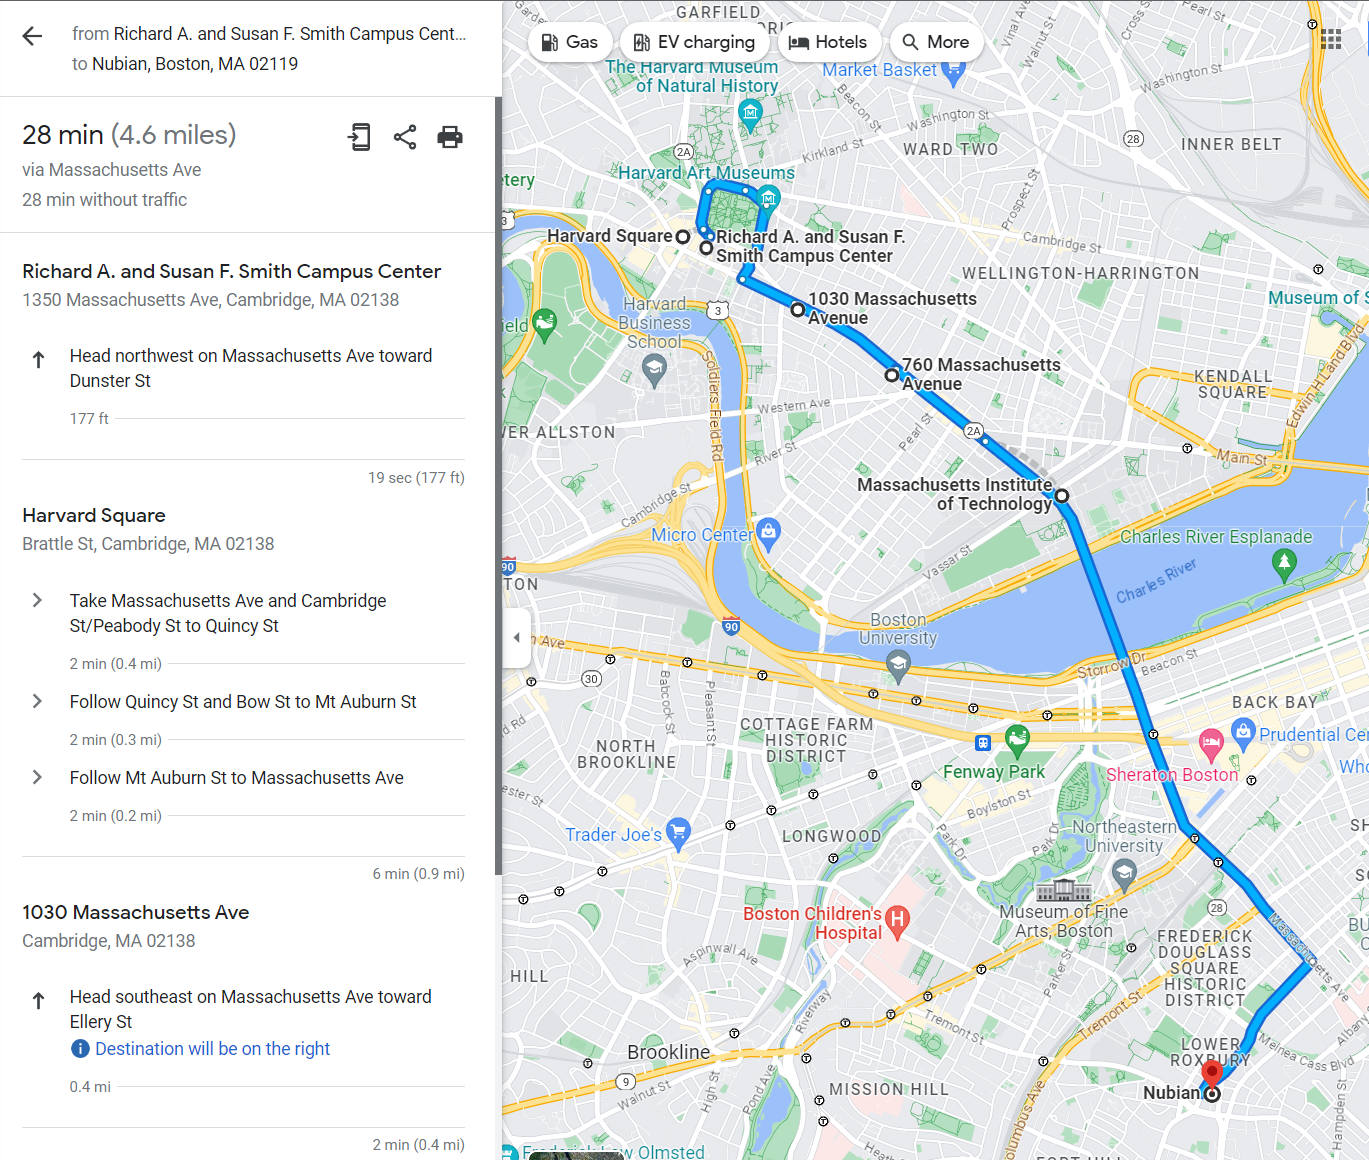

As shown in the above screenshot, the Google Maps estimate of the mileage along route 1 is: __4.6 miles.__ This estimate is probably more accurate than the Haversine distance (which is like drawing a straight line from Harvard to Nubian Station) so we are keeping the 4.6 miles value instead of the 3.5 miles one.

Given this estimate of route length and the previously calculated median trip duration, we can now estimate the average speed of the bus (in mph).

In [21]:
Route1Length = 4.6;
print('Route 1 average speed (in mph) :', Route1Length / df_trips['trip_duration'].median().total_seconds() * 60 * 60)

Route 1 average speed (in mph) : 6.803615447822515


In conclusion, the average speed of the route 1 bus during these 3 days of data recording was approximately __6.8 mph.__ This is about twice as fast as casual walking (which is 3 or 3.5 mph). Having taken this bus line many times myself, I would say that it matches my experience!

____